In [1]:
import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt

from copy import deepcopy

In [2]:
np.random.seed(32)

### Data Generation

In [3]:
def Line(samples):

    xdata = []
    ydata = []

    for i in range(samples):
        x = np.random.uniform(-1, 1)
        y = x

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = True) , np.array(ydata, requires_grad = False)

# --------------------------------------------------- #

def Exp(samples):
    xdata = []
    ydata = []

    for i in range(samples):
        x = np.random.uniform(-1, 1)
        y = np.exp(x-1)

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = True) , np.array(ydata, requires_grad = False)

# --------------------------------------------------- #

def Inverse(samples):
    xdata = []
    ydata = []
    
    for i in range(samples):
        xarr = np.arange(-1, 1.02, 1/50)
        x = np.random.choice(xarr)
        y = 1 / (50*x)

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = True) , np.array(ydata, requires_grad = False)

# --------------------------------------------------- #

def Square(samples):
    xdata = []
    ydata = []
    
    for i in range(samples):
        x = np.random.uniform(-1, 1)
        y = x**2

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = True) , np.array(ydata, requires_grad = False)

def Cos(samples):
    xdata = []
    ydata = []

    for i in range(samples):
        x = np.random.uniform(-np.pi, np.pi)
        y = np.cos(x)

        xdata.append(x)
        ydata.append(y)
    
    return np.array(xdata, requires_grad = True) , np.array(ydata, requires_grad = False)

In [4]:
#sum = xdata[:,0] + 2*xdata[:,1] 
#print(sum)
'''
plt.plot(xlin, np.cos(xlin))
plt.scatter(sum, ydata, color = 'red', s = 9, marker = 'x', alpha = 0.7)
plt.grid(True)
plt.title("f(x) = cos(x)")
plt.show()
'''

'\nplt.plot(xlin, np.cos(xlin))\nplt.scatter(sum, ydata, color = \'red\', s = 9, marker = \'x\', alpha = 0.7)\nplt.grid(True)\nplt.title("f(x) = cos(x)")\nplt.show()\n'

In [5]:
dev = qml.device('default.qubit', wires= 100)

@qml.qnode(dev)
def Fun_1dim(x, thetas, num_qubits, num_layers):
    idx = 0

    for _ in range(num_layers):
        StronglyEntanglingLayers(thetas[idx], wires=range(num_qubits))
        
        for i in range(num_qubits):
            qml.RX(x, wires = i, id = f"x upload")
        
        idx += 1

    StronglyEntanglingLayers(thetas[-1], wires=range(num_qubits))

    #return [qml.expval(qml.PauliZ(i)) for i in range(dim)]
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
        obs @= qml.PauliZ(i+1)

    return qml.expval(obs)

In [6]:
xdata , ydata = Square(1)

num_layers = 2
num_qubits = 4

thetas = np.random.uniform(size=(num_layers+1, 1, num_qubits, 3), requires_grad=True)
#print(thetas)
#print(thetas[0])
print(qml.draw(Fun_1dim, expansion_strategy="device")(xdata[0], thetas, num_qubits, num_layers))
y = [Fun_1dim(x_, thetas, num_qubits, num_layers) for x_ in xdata]
print(y)

0: ──Rot(0.56,0.96,0.74)─╭●───────╭X──RX(-0.25,"x upload")──Rot(0.55,0.70,0.59)─╭●───────╭X
1: ──Rot(0.82,0.10,0.93)─╰X─╭●────│───RX(-0.25,"x upload")──Rot(0.05,0.56,0.77)─╰X─╭●────│─
2: ──Rot(0.61,0.60,0.09)────╰X─╭●─│───RX(-0.25,"x upload")──Rot(0.91,0.09,0.90)────╰X─╭●─│─
3: ──Rot(0.35,0.66,0.44)───────╰X─╰●──RX(-0.25,"x upload")──Rot(0.46,0.45,1.00)───────╰X─╰●

───RX(-0.25,"x upload")──Rot(0.16,0.71,0.16)─╭●───────╭X─┤ ╭<Z@Z@Z@Z>
───RX(-0.25,"x upload")──Rot(0.81,0.04,0.53)─╰X─╭●────│──┤ ├<Z@Z@Z@Z>
───RX(-0.25,"x upload")──Rot(0.17,0.31,0.05)────╰X─╭●─│──┤ ├<Z@Z@Z@Z>
───RX(-0.25,"x upload")──Rot(0.24,0.67,0.78)───────╰X─╰●─┤ ╰<Z@Z@Z@Z>
[tensor(0.43255745, requires_grad=True)]


In [7]:
yz = [qml.grad(Fun_1dim)(x_, thetas, num_qubits, num_layers)[0] for x_ in xdata]
print(yz)
print(ydata)

[tensor(0.12893572, requires_grad=True)]
[0.0648098]


In [8]:
def cost_function(xdata, thetas, num_qubits, num_layers, ydata):
    ypred = [qml.grad(Fun_1dim)(x_, thetas, num_qubits, num_layers)[0] for x_ in xdata]
    loss = 0
    np.array(ypred)
    for i in range(len(ydata)):
        loss += (ydata[i] - ypred[i]) ** 2

    return loss / len(ydata)

In [9]:
def model_running(xdata, thetas, num_qubits, num_layers):
    exp = [Fun_1dim(x_, thetas, num_qubits, num_layers) for x_ in xdata]
    diffpred = [qml.grad(Fun_1dim)(x_, thetas, num_qubits, num_layers)[0] for x_ in xdata]

    return np.array(exp), np.array(diffpred)

-----

In [14]:
train_data, train_target = Square(10)
test_data, test_target = Square(25)

# Trainnig option settings
num_qubits = 2
num_layers = 4
epochs = 50
#batch_size = 50
lr = 0.05

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
thetas = np.random.uniform(size=(num_layers+1, 1, num_qubits, 3), requires_grad=True)
#print(thetas)

In [15]:
exp_train, diff_train  = model_running(train_data, thetas, num_qubits, num_layers)
exp_test, diff_test = model_running(test_data, thetas, num_qubits, num_layers)

# Saving predictions with random weights for comparison 
initial_diff = diff_test
initial_exp = exp_test

loss = cost_function(train_data, thetas, num_qubits, num_layers, train_target)
loss_list = [loss]

print(
    "Epoch: {:2d} | Cost: {:3f} |".format(
        0, loss.item()
    )
)

for it in range(epochs):
    _, thetas, _, _, _ = opt.step(cost_function, train_data, thetas, num_qubits, num_layers, train_target)

    exp_train, diff_train = model_running(train_data, thetas, num_qubits, num_layers)
    loss = cost_function(train_data, thetas, num_qubits, num_layers, train_target)

    exp_test, diff_test = model_running(test_data, thetas, num_qubits, num_layers)

    res = [it + 1, loss.item()]
    print(
        "Epoch: {:2d} | Loss: {:3f} |".format(
            *res
        )
    )

    loss_list.append(loss)

Epoch:  0 | Cost: 0.635876 |
Epoch:  1 | Loss: 0.357421 |
Epoch:  2 | Loss: 0.169681 |
Epoch:  3 | Loss: 0.068605 |
Epoch:  4 | Loss: 0.027230 |
Epoch:  5 | Loss: 0.017378 |
Epoch:  6 | Loss: 0.017712 |
Epoch:  7 | Loss: 0.016584 |
Epoch:  8 | Loss: 0.011731 |
Epoch:  9 | Loss: 0.007574 |
Epoch: 10 | Loss: 0.007219 |
Epoch: 11 | Loss: 0.009851 |
Epoch: 12 | Loss: 0.012403 |
Epoch: 13 | Loss: 0.012358 |
Epoch: 14 | Loss: 0.010251 |
Epoch: 15 | Loss: 0.008031 |
Epoch: 16 | Loss: 0.007018 |
Epoch: 17 | Loss: 0.007466 |
Epoch: 18 | Loss: 0.008184 |
Epoch: 19 | Loss: 0.007718 |
Epoch: 20 | Loss: 0.006160 |
Epoch: 21 | Loss: 0.004517 |
Epoch: 22 | Loss: 0.003522 |
Epoch: 23 | Loss: 0.003287 |
Epoch: 24 | Loss: 0.003158 |
Epoch: 25 | Loss: 0.002581 |
Epoch: 26 | Loss: 0.001749 |
Epoch: 27 | Loss: 0.001140 |
Epoch: 28 | Loss: 0.001065 |
Epoch: 29 | Loss: 0.001347 |
Epoch: 30 | Loss: 0.001437 |
Epoch: 31 | Loss: 0.001160 |
Epoch: 32 | Loss: 0.000768 |
Epoch: 33 | Loss: 0.000610 |
Epoch: 34 | Lo

Learned weights
thetas = [[[[ 0.61122462 -0.06250772  1.02214351]
   [ 0.04400528 -0.05525588  0.19081823]]]


 [[[ 0.72161329  0.87276122  0.62710286]
   [ 0.37328232 -0.67720229  0.22320557]]]


 [[[ 0.82729533  1.09821184  1.1140332 ]
   [ 0.54732915  0.59429872  0.80855323]]]


 [[[-0.10784374  0.24405018  0.85262453]
   [-0.09874179  0.95820956  0.30536443]]]


 [[[ 0.3404079   1.01723155  0.08563918]
   [ 0.05166892  0.38883048  0.47596747]]]]
25 25 25 25 25 25


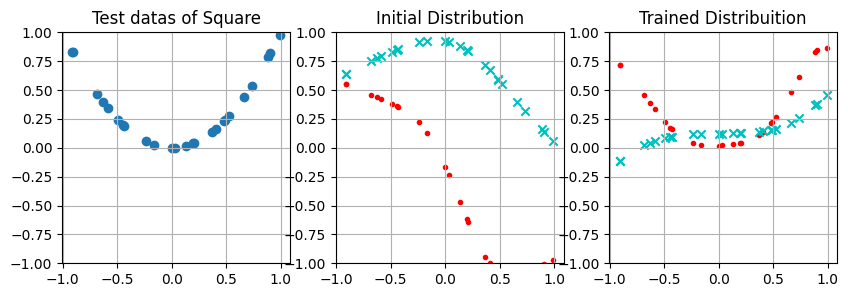

In [16]:
print("Learned weights")
print("thetas = {}".format(thetas))

fig, axis = plt.subplots(1, 3, figsize=(10, 3))

axis[0].scatter(test_data, test_target, label = "cox(x)")
axis[1].scatter(test_data, initial_diff, color = 'red', marker = '.', label = "differentiate x")
axis[1].scatter(test_data, initial_exp, color = 'c', marker = 'x', label = 'expecatation value')
axis[2].scatter(test_data, diff_test, color = 'red', marker = '.', label = "differentiate x")
axis[2].scatter(test_data, exp_test, color = 'c', marker = 'x', label = 'expecatation value')

axis[0].set_ylim((-1,1))
axis[1].set_ylim((-1,1))
axis[2].set_ylim((-1,1))

axis[0].grid(True)
axis[1].grid(True)
axis[2].grid(True)

axis[0].set_title("Test datas of Square")
axis[1].set_title("Initial Distribution")
axis[2].set_title("Trained Distribuition")

axis[0].grid(True)
plt.show()

In [19]:
def Integration(xmin, xmax, thetas, num_qubits,num_layers):
    upper = Fun_1dim(xmax, thetas, num_qubits, num_layers)
    lower = Fun_1dim(xmin, thetas, num_qubits, num_layers)
    
    return upper - lower

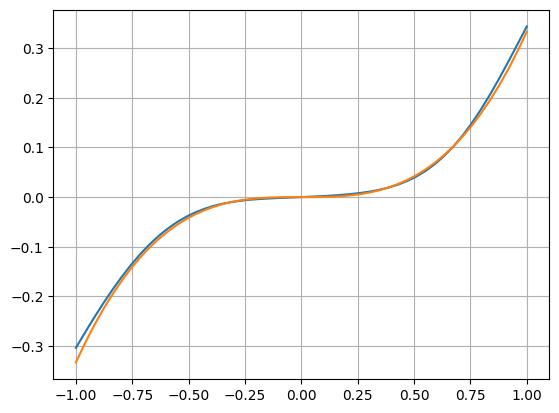

In [26]:
xlin = np.linspace(-1, 1)
integral = Integration(0, xlin, thetas, num_qubits, num_layers)
plt.plot(xlin, integral, label = 'VQC approxi')
plt.plot(xlin, 1/3*xlin**3, label = 'target')
plt.grid()
plt.show()